In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 前処理
df = pd.read_csv('XRP_JPY.csv', encoding='utf-8')
df = df.drop(["始値", "高値", "安値", "出来高", "変化率 %"], axis=1)
df = df.rename(columns={'終値': 'Close', "日付け": 'Date'})
df.set_index("Date", inplace=True)
df = df.sort_index()
df

,Close
Date,
2018-01-23,152.900
2018-01-24,147.820
2018-01-25,146.000
2018-01-26,126.800
2018-01-27,136.104
...,...
2023-11-30,89.793
2023-12-01,90.054
2023-12-02,91.195


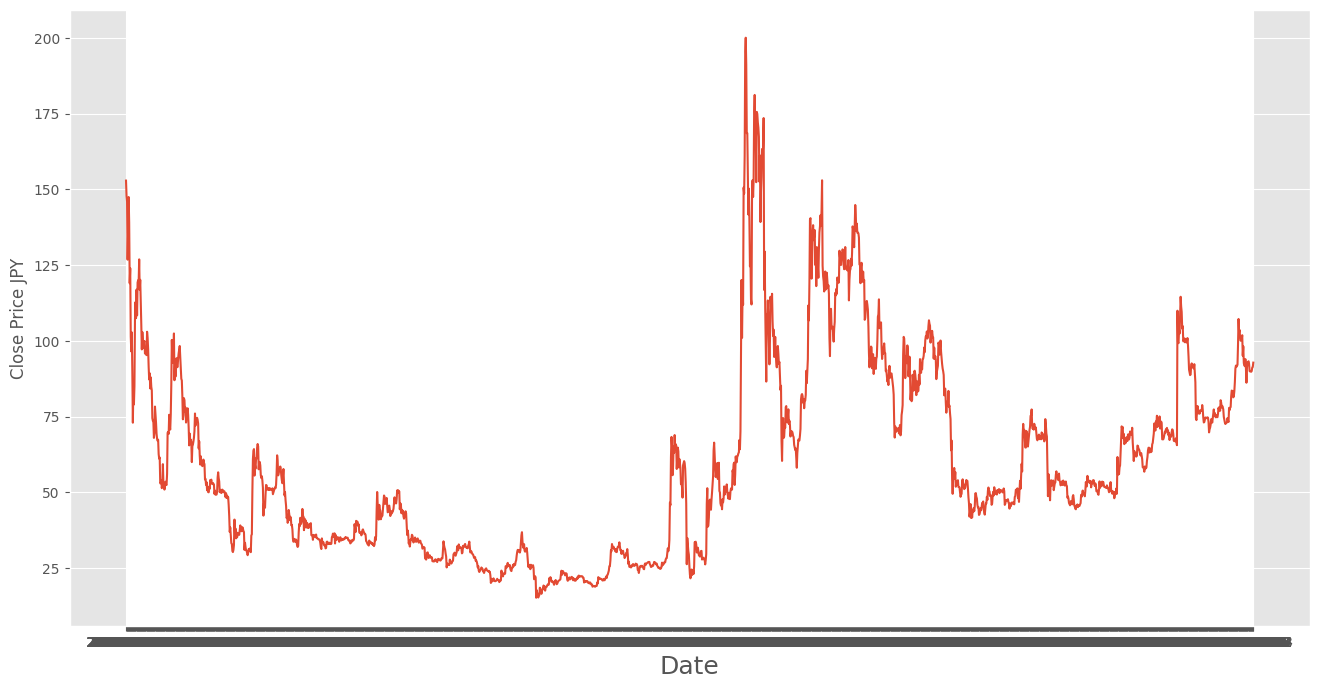

In [3]:
plt.figure(figsize=(16, 8))
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price JPY")
plt.show()

In [4]:
# 正規化
train = df.loc[:"2021-12-31"].values
test = df.loc["2022-01-01":].values
scaler = MinMaxScaler(feature_range=(0, 1))
scalar = scaler.fit(train)
scaled_train_data = scaler.transform(train)
scaled_test_data = scaler.transform(test)

In [14]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, sequence_size: int) -> Tuple[np.ndarray, np.ndarray]:
    num_data = len(data)
    seq_data = []
    target_data = []
    for i in range(num_data - sequence_size):
        seq_data.append(data[i:i+sequence_size])
        target_data.append(data[i+sequence_size:i+sequence_size+1])
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [17]:
seq_length = 30
train_X, train_Y = make_sequence_data(scaled_train_data, seq_length)
test_X, test_Y = make_sequence_data(scaled_test_data, seq_length)

tensor_train_X = torch.FloatTensor(train_X).permute(1, 0, 2)
tensor_train_Y = torch.FloatTensor(train_Y).permute(1, 0, 2)
tensor_test_X = torch.FloatTensor(test_X).permute(1, 0, 2)

test_Y = test_Y.reshape(len(test_Y), 1)

In [18]:
class LSTM(nn.Module):
    def __init__(self, hidden_size=100):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x_last = x[-1]
        x = self.linear(x_last)

        return x

In [19]:
model = LSTM(100)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
epochs = 100
losses = []
with tqdm(total=epochs, desc='Training', position=0) as pbar:
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(tensor_train_X)
        loss = criterion(output, tensor_train_Y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        pbar.update()
    

Training:   0%|          | 0/100 [00:00<?, ?it/s]/home/naoya/ai/lstm_virtual_currency_forecast/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1409, 1])) that is different to the input size (torch.Size([1409, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


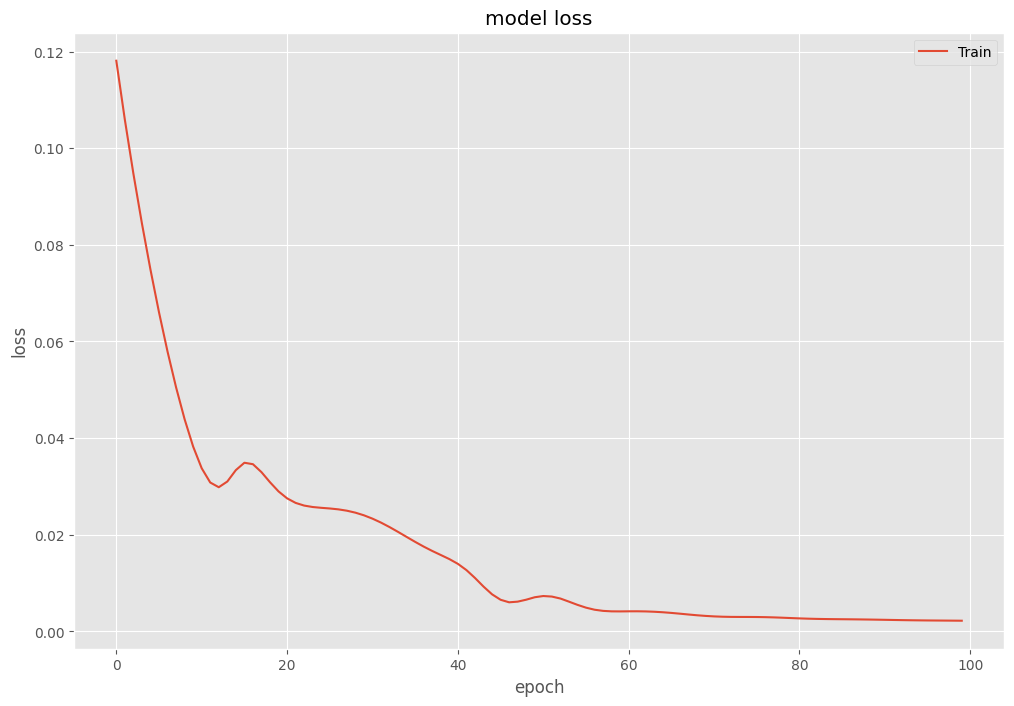

In [23]:
plt.figure(figsize=(12, 8))
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(losses)
plt.legend(["Train"])
plt.show()